In [1]:
# auto updates code chnages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import importlib
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


basepath = os.path.dirname(os.path.dirname(os.getcwd()))
if basepath not in sys.path:
    sys.path.append(basepath)
import analysis as an

# Set up Notebook to show all output from cells
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [10]:
data_dict = {}
for sim in [an.MarvelSim.CAPTAINMARVEL] + list(an.JusticeLeagueSim):
    data_dict[sim.value] = {}
    # z=0 halo ids
    # globals()[f'{sim.value}_z0halos'] = an.get_massive_haloids(sim)
    data_dict[sim.value]['z0halos'] = an.get_massive_haloids(sim)

    # expelled particles mlf
    data = pd.read_hdf( f"Data/analysis/{sim.value}.hdf5", key="expelled_mlf")
    # globals()[f'{sim.value}_expelled_mlf'] = data['mlf'].to_numpy()
    data_dict[sim.value]['expelled_mlf'] = data['mlf'].to_numpy()
                 
    # halo masses
    data = pd.read_hdf(f"Data/analysis/{sim.value}.hdf5", key="mass_properties")
    # globals()[f'{sim.value}_halo_masses'] = data["halo_mass"].to_numpy()
    data_dict[sim.value]['halo_masses'] = data["halo_mass"].to_numpy()

    # stellar masses
    # globals()[f'{sim.value}_stellar_masses'] = data["stellar_mass"].to_numpy()
    data_dict[sim.value]['stellar_masses'] = data["stellar_mass"].to_numpy()


In [19]:
InteractiveShell.ast_node_interactivity = "last_expr"
%config InlineBackend.figure_format = 'retina' # For high-res (retina) displays

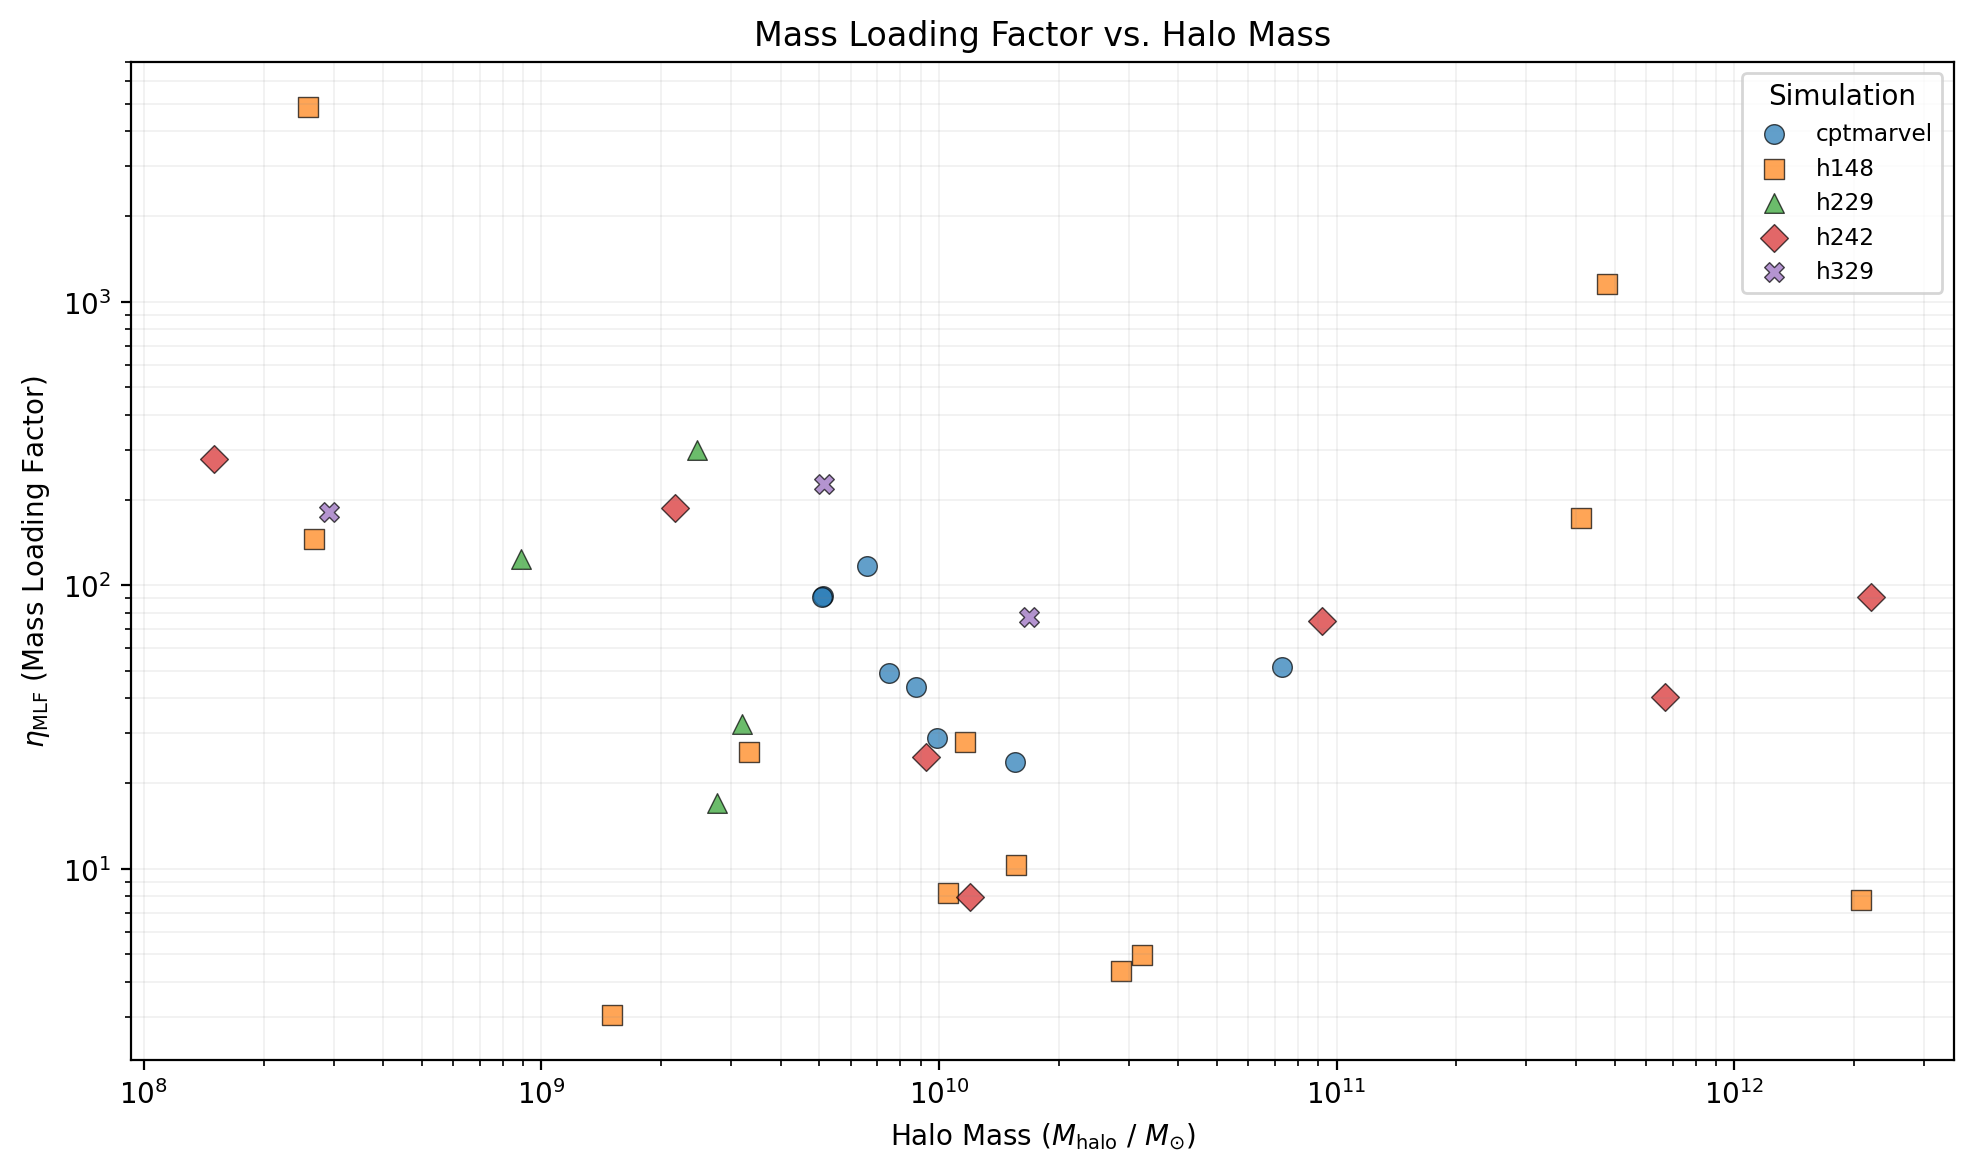

In [20]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
markers = ['o', 's', '^', 'D', 'X', 'P', '*', 'h', '+', 'v'] # More distinct markers

plt.figure(figsize=(10, 6))
ax = plt.gca() # Get the current axes object

for i, key in enumerate(data_dict):
    ax.scatter(
        data_dict[key]['halo_masses'],
        data_dict[key]['expelled_mlf'],
        label=key,
        color=colors[i % len(colors)],      # Cycle through predefined colors
        marker=markers[i % len(markers)],   # Cycle through predefined markers
        s=50,                               # Marker size
        alpha=0.7,                          # Transparency
        edgecolors='black',                 # Black edge for markers
        linewidth=0.5                       # Thin linewidth for edge
    )

# Axis labels with LaTeX formatting for symbols and units
ax.set_xlabel(r'Halo Mass ($M_{\text{halo}}$ / $M_{\odot}$)') # Example: If M_star, change to Stellar Mass
ax.set_ylabel(r'$\eta_{\text{MLF}}$ (Mass Loading Factor)')
ax.set_title(r'Mass Loading Factor vs. Halo Mass') # More descriptive title

# Log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Grid lines (minor ticks included)
ax.grid(True, which="both", ls="-", lw=0.1, color='gray', alpha=0.7)
ax.minorticks_on() # Ensure minor ticks are on for log plots

# Legend (positioned to avoid data)
# bbox_to_anchor for outside plot; loc='best' if inside is fine
ax.legend(title='Simulation', loc='best', fontsize='small')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

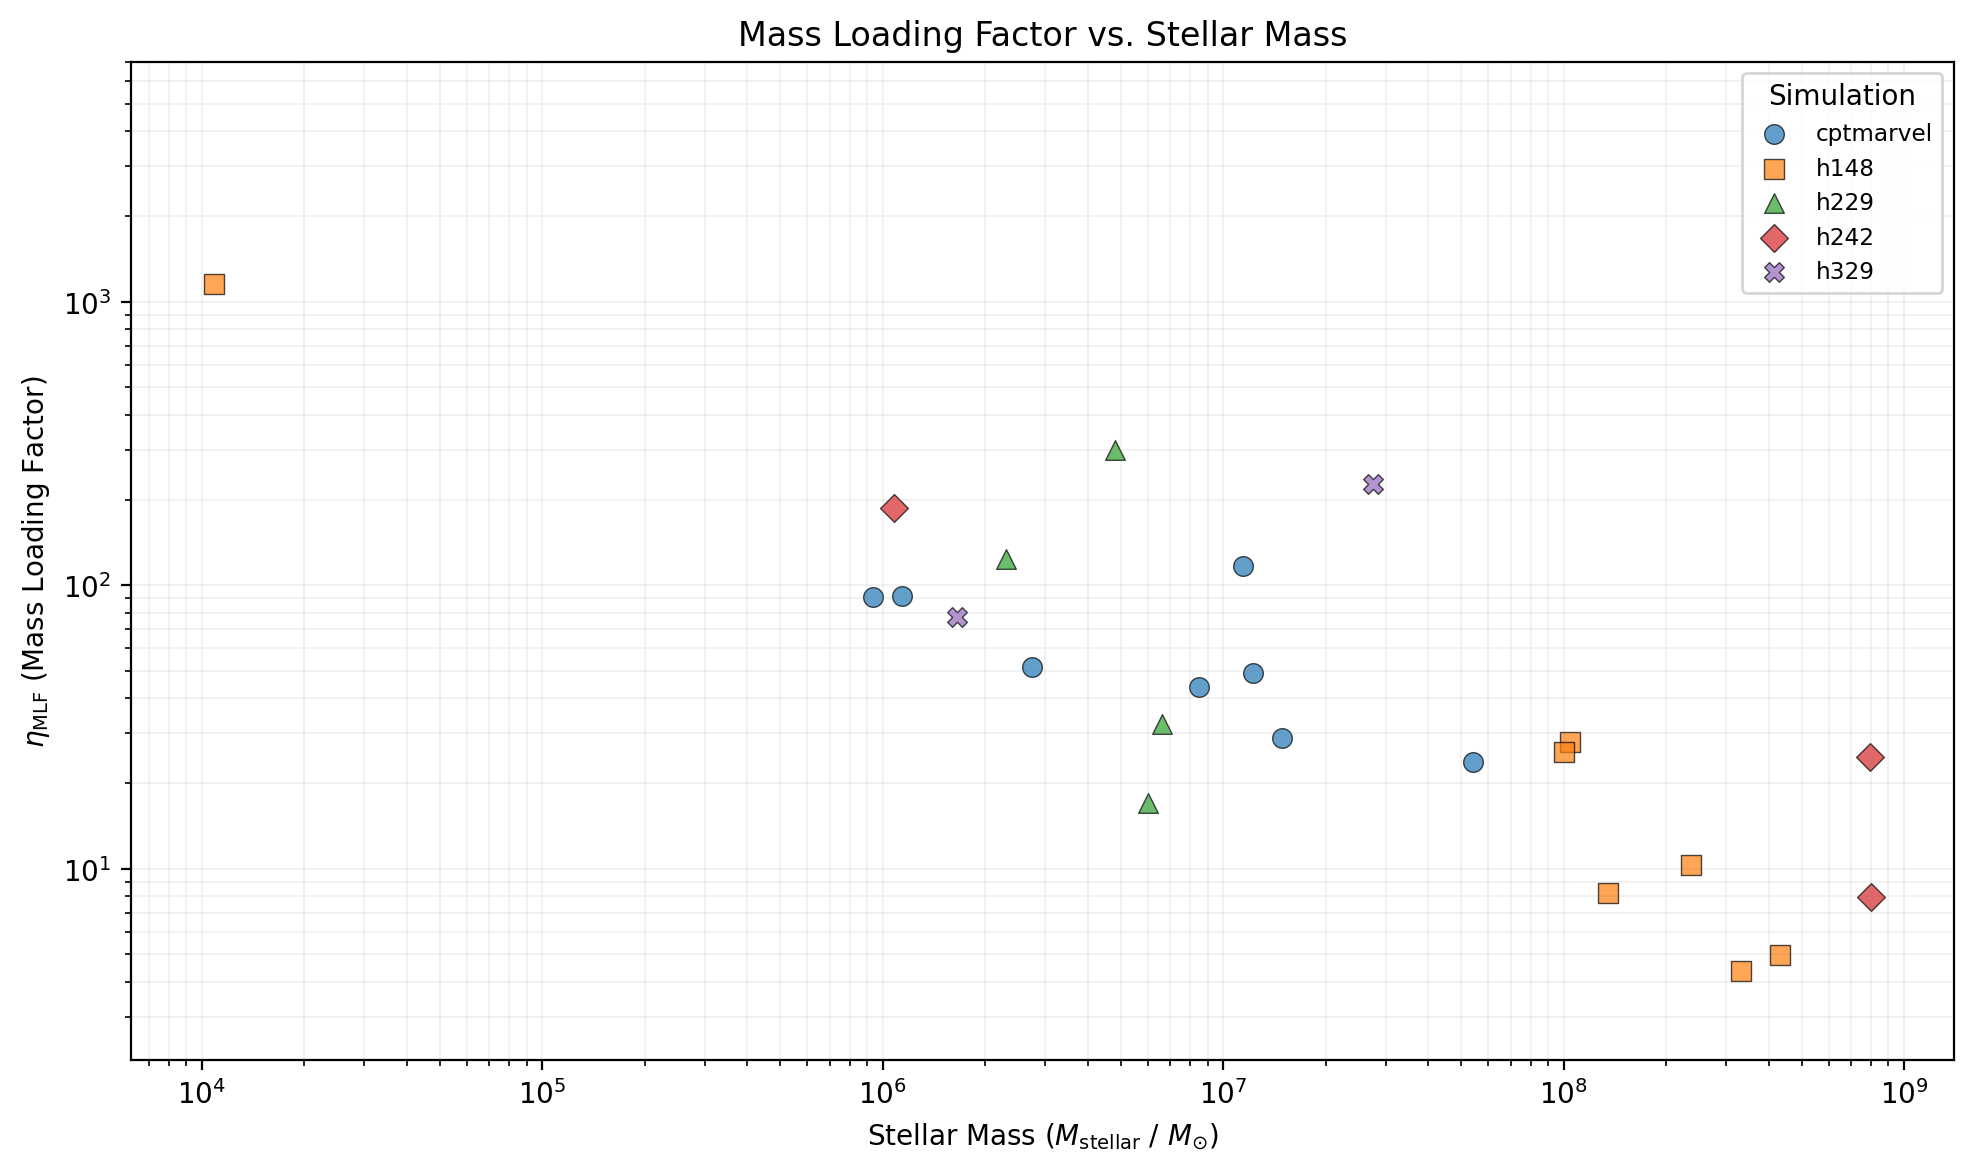

In [21]:
plt.figure(figsize=(10, 6))
ax = plt.gca() 

for i, key in enumerate(data_dict):
    ax.scatter(
        data_dict[key]['stellar_masses'],
        data_dict[key]['expelled_mlf'],
        label=key,
        color=colors[i % len(colors)],      # Cycle through predefined colors
        marker=markers[i % len(markers)],   # Cycle through predefined markers
        s=50,                               # Marker size
        alpha=0.7,                          # Transparency
        edgecolors='black',                 # Black edge for markers
        linewidth=0.5                       # Thin linewidth for edge
    )

# Axis labels with LaTeX formatting for symbols and units
ax.set_xlabel(r'Stellar Mass ($M_{\text{stellar}}$ / $M_{\odot}$)') # Example: If M_star, change to Stellar Mass
ax.set_ylabel(r'$\eta_{\text{MLF}}$ (Mass Loading Factor)')
ax.set_title(r'Mass Loading Factor vs. Stellar Mass') # More descriptive title

# Log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Grid lines (minor ticks included)
ax.grid(True, which="both", ls="-", lw=0.1, color='gray', alpha=0.7)
ax.minorticks_on() # Ensure minor ticks are on for log plots

# Legend (positioned to avoid data)
# bbox_to_anchor for outside plot; loc='best' if inside is fine
ax.legend(title='Simulation', loc='best', fontsize='small')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()